## Homework 5.4 

a)
combine the title and abstract. 

bigrams are sequences of 2 words. 
unigrams are single words.
Therefore, the tokens are twice as long for text that is tokenized into bigrams

In [373]:
import nltk
import re
from typing import List, Set
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation

In [374]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
# Include punctuation in the stop words set
# Additional punctuation
stop_words.update({'...', '``', "''"})




documents = []
with open('scopusabstracts.csv', 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split('#')
        if len(parts) == 3:
            doc_id, title, abstract = parts
            combined_text = title + ' ' + abstract
            documents.append(combined_text)
# deleting the title thingy
documents = documents[1:]

[nltk_data] Downloading package stopwords to /home/praita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/praita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [375]:

class Preprocessor:
    def __init__(self, documents: List[str], custom_stopwords: Set[str] = None):
        """
        Initializes the Preprocessor with a list of documents and an optional set of custom stopwords.
        
        :param documents: List of raw text documents.
        :param custom_stopwords: Set of additional stopwords to include.
        """
        self.documents = documents
        self.tokens_list: List[List[str]] = []
        self.cleaned_tokens_list: List[List[str]] = []
        self.cleaned_documents: List[str] = []
        
        # Initialize stop words
        self.stop_words: Set[str] = set(stopwords.words('english'))
        if custom_stopwords:
            self.stop_words.update(custom_stopwords)
        # Include punctuation and additional symbols in stop words
        self.stop_words.update(set('''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'''))
        self.stop_words.update({'...', '``', "''"})
        
        # Initialize stemmer
        self.stemmer = PorterStemmer()
    
    def tokenize_documents(self) -> List[List[str]]:
        """Tokenizes the documents and converts tokens to lowercase."""
        self.tokens_list = [word_tokenize(doc.lower()) for doc in self.documents]
        return self.tokens_list
    
    def remove_stopwords(self) -> List[List[str]]:
        """Removes stopwords from the tokenized documents."""
        if not self.tokens_list:
            self.tokenize_documents()
        self.tokens_list = [
            [token for token in tokens if token not in self.stop_words]
            for tokens in self.tokens_list
        ]
        return self.tokens_list
    
    def remove_numbers(self) -> List[List[str]]:
        """Removes numbers and non-alphabetic tokens from the tokenized documents."""
        self.tokens_list = [
            # here, the regular expression package re, substitutes all 
            # r'\d+': This is a regular expression pattern where \d matches any digit (0-9), 
            # and + means "one or more" of the preceding 
            [re.sub(r'\d+', '', token) for token in tokens]
            for tokens in self.tokens_list
        ]
        self.tokens_list = [
            [token for token in tokens if token.isalpha()]
            for tokens in self.tokens_list
        ]
        return self.tokens_list
    
    def stem_tokens(self) -> List[List[str]]:
        """Applies stemming to the tokens."""
        self.tokens_list = [
            [self.stemmer.stem(token) for token in tokens]
            for tokens in self.tokens_list
        ]
        return self.tokens_list
    
    def preprocess(self) -> List[str]:
        """
        Runs the full preprocessing pipeline:
        Tokenization -> Lowercasing -> Stopword Removal -> Number Removal -> Stemming
        """
        self.tokenize_documents()
        self.remove_stopwords()
        self.remove_numbers()
        self.stem_tokens()
        # joins the tokes from the token list into a list of documents 
        self.cleaned_documents = [' '.join(tokens) for tokens in self.tokens_list]
        return self.cleaned_documents


### Observation

If the stemming is done before the stop word removal, that stems some stop words and thus they are then not recognized in the stop word removal. 
an example of the phenomenon is word 'this', which gets stemmed to 'thi' , which is then not recognized.  


lowercasing also causes problems. 

In [376]:
custom_stopwords = {'abstract', 'title', 'method', 'result', 'study', 'approach', 'data', 'using'}

# Initialize the Preprocessor
preprocessor = Preprocessor(documents, custom_stopwords= custom_stopwords)

# Run the full preprocessing pipeline
cleaned_documents = preprocessor.preprocess()

# Now, cleaned_documents contains the preprocessed text ready for vectorization
print("Cleaned Documents:")
for doc in cleaned_documents[:5]:
    print(doc)# Optional: Print the preprocessed tokens

Cleaned Documents:
anomali detect wide area imageri geniş alan görüntülerind anomali tespiti detect anomali wide area imageri collect aircraft set anomali identifi anyth normal cours action purpos two differ set use experi carri set anomali detect convolut neural network model tri gener next imag past imag design imag given model anomali detect perform compar estim imag true imag
person deep match random walk person aim robustli measur visual affin person imag wide applic intellig surveil associ person imag across multipl camera gener treat imag retriev problem given probe person imag affin probe imag galleri imag pg affin use rank retriev galleri imag exist two main challeng effect solv problem person imag usual show signific variat differ person pose view angl spatial layout correspond person imag therefor vital inform tackl problem method either ignor spatial variat util extra pose inform handl challeng exist person method rank galleri imag consid pg affin ignor affin galleri imag g

In [377]:
tfidf_vectorizer = TfidfVectorizer(
    # ngram_range: specifies the range of n-grams to extract from the text data
    # (1, 2) means both unigrams and bigrams will be considered
    ngram_range=(1, 2),
    # min_df: minimum document frequency; ignore terms that appear in less than this number of documents
    min_df=5,
    # max_df: maximum document frequency; ignore terms that appear in more than this fraction of documents
    max_df=0.8,
    # stop_words: list of stop words to ignore in the vectorization process
    stop_words=list(stop_words),
    # lowercase: convert all the text to lowercase
    lowercase=True,
    # use_idf: enable inverse-document-frequency reweighting
    use_idf=True,
    # norm: specifies the norm used to normalize the vectors
    # 'l2' is the Euclidean norm, which scales the vectors to unit length
    norm='l2'
)


TF-IDF Matrix: A 2D matrix where:

Rows represent documents.
Columns represent terms (unigrams or bigrams).
Values are the TF-IDF scores.


In [378]:
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_documents)


In [379]:
# Step 5: Inspect the TF-IDF matrix
print("TF-IDF matrix shape: {}".format(tfidf_matrix.shape))
print("\nSample features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:20])



TF-IDF matrix shape: (1143, 3433)

Sample features:
['abil' 'abl' 'abnorm' 'absenc' 'absolut' 'abstract' 'acceler'
 'acceleromet' 'accept' 'access' 'access control' 'access databas' 'accid'
 'accomplish' 'accord' 'accordingli' 'account' 'accumul' 'accur'
 'accur estim']


In [380]:
import numpy as np
# Optional: Print the TF-IDF values of the first document
print("\nThe TF-IDF values of the first document:")
first_doc_vector = tfidf_matrix[0]
print(first_doc_vector.shape)

# Use .A.flatten() to get a 1D array of values
# Changed from set(first_doc_vector.A.flatten()) to first_doc_vector.A.flatten() to avoid duplicates
for value in np.unique(first_doc_vector.toarray()):
    print(value)

first_doc_features = first_doc_vector.nonzero()
print(first_doc_features[0].size)

# Corrected the zip function to use the correct indexing
tfidf_scores = zip(first_doc_features[1], [first_doc_vector[0, x] for x in first_doc_features[1]])
for idx, score in tfidf_scores:
    print(f"{feature_names[idx]}: {score}")


The TF-IDF values of the first document:
(1, 3433)
0.0
0.033225854208002746
0.03842580175928087
0.04502428492647172
0.04576392079304923
0.045826800142899596
0.04880780720019409
0.05096359656539803
0.051877901681973676
0.05591253524490558
0.06576191468766365
0.06809328101121703
0.06886848486316155
0.06988140233502144
0.07230706938955263
0.07326690866287257
0.07401803219736516
0.0776413695402861
0.07990084873875279
0.0824460228559518
0.08347394160304836
0.08627593647966848
0.09287019783574559
0.09641488994606766
0.09802797584814316
0.10273597279014242
0.10382557951298337
0.10619923927341876
0.10749987216820321
0.1088902727627611
0.12016810636353462
0.12596571002837484
0.13019129047519387
0.1432320960513853
0.16589608938887904
0.20995496493733776
0.22039267713329322
0.2611046830363797
0.3470134067804366
0.6533416365765666
41
anomali: 0.6533416365765666
detect: 0.22039267713329322
wide: 0.1432320960513853
area: 0.13019129047519387
imageri: 0.20995496493733776
collect: 0.07326690866287257


In [381]:
import pandas as pd

# Let's take the first 5 documents and first 10 features
num_docs = 5
num_features = 10

# Convert the TF-IDF matrix to a dense format (warning: can be memory-intensive)
tfidf_dense = tfidf_matrix[:num_docs, :num_features].todense()

# Create a DataFrame
df_tfidf = pd.DataFrame(tfidf_dense, columns=feature_names[:num_features])

print("TF-IDF scores for the first 5 documents and first 10 features:")
print(df_tfidf)


TF-IDF scores for the first 5 documents and first 10 features:
       abil  abl  abnorm  absenc  absolut  abstract  acceler  acceleromet  \
0  0.000000  0.0     0.0     0.0      0.0       0.0      0.0          0.0   
1  0.034432  0.0     0.0     0.0      0.0       0.0      0.0          0.0   
2  0.118893  0.0     0.0     0.0      0.0       0.0      0.0          0.0   
3  0.000000  0.0     0.0     0.0      0.0       0.0      0.0          0.0   
4  0.000000  0.0     0.0     0.0      0.0       0.0      0.0          0.0   

   accept  access  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     0.0  
3     0.0     0.0  
4     0.0     0.0  


In [382]:
# Get the TF-IDF vector for the first document (NOTE NUMBER 0 IS JUST THE title document)
# ... since the rows are the documents
first_doc_vector = tfidf_matrix[1]

# Convert it to a dense format (array)
first_doc_array = first_doc_vector.toarray()[0]

# Get indices of terms with non-zero TF-IDF scores
nonzero_indices = first_doc_vector.nonzero()[1]
# print("nonzero_indices length ", nonzero_indices)
# print(feature_names[nonzero_indices])
# [print(feature_names[i], "for index ", i)  for i in nonzero_indices]
# Get the terms and their TF-IDF scores
tfidf_scores = {feature_names[i]: first_doc_array[i] for i in nonzero_indices}

# Sort the terms by TF-IDF score in descending order
# The lambda function is used to specify a sorting key, in this case, it sorts the tfidf_scores dictionary items by their values (item[1]) in descending order (reverse=True)
sorted_terms = sorted(tfidf_scores.items(), key=lambda item: item[1], reverse=True)

# Display the top terms
print("Top terms in the first document:")
for term, score in sorted_terms[:10]:
    print(f"{term}: {score}")


Top terms in the first document:
person: 0.5149838227055089
affin: 0.47563641312474597
imag: 0.32800499864938604
rank: 0.19809473490273236
match: 0.1452774583941071
walk: 0.1429388982283215
variat: 0.1412944742873525
pose: 0.11877153581184455
learn framework: 0.11302905701391283
probe: 0.11024153096888854


## 5.4 b)  clustering


cluster the data with K-means 3 .. 10



In [383]:
from sklearn.cluster import KMeans


import numpy as np

from sklearn.metrics import davies_bouldin_score

### evaluation of cluster quality with Davies Bouding Score

### finding the optimal K

In [384]:
def db_score_clusters(tfidf_matrix, cluster_range: np.ndarray) -> dict: 
    """ 
    calculates optimal cluster number
    returns the dict of {cluster, db score} 
    """
    db_scores = {}
    for clusterindex in cluster_range:
        # Initialize the KMeans model
        kmeans = KMeans(n_clusters=clusterindex, random_state=42)

        # Fit the model to the TF-IDF matrix
        kmeans.fit(tfidf_matrix)
        # Get the cluster labels assigned to each document
        cluster_labels = kmeans.labels_

        db_index = davies_bouldin_score(tfidf_matrix.toarray(), cluster_labels)
        db_scores[clusterindex] = (db_index)
        # print(f"Davies-Bouldin Index for {clusterindex} clusters: {db_index}")
    
    return db_scores

def find_optimal_cluster(db_dict)-> int:
    """ 
    takes in dictionary containing cluster numbers and respective db scores
    returns optimal cluster number
    """
    # RETURNING THE BEST CLUSTER:
    min_db_score = min(db_dict.values())
    # picks the first of the optimal clusters
    optimal_cluster = [cluster_num for cluster_num, db_value in db_dict.items() if db_value == min_db_score][0]
    return optimal_cluster


In [385]:
# this is range 3.. 10
cluster_range = np.arange(3, 11)
db_dict = db_score_clusters(tfidf_matrix=tfidf_matrix, cluster_range=cluster_range)
optimal_cluster = find_optimal_cluster(db_dict=db_dict)
print(optimal_cluster)
optimal_kmeans = KMeans(n_clusters=optimal_cluster)
optimal_kmeans.fit(tfidf_matrix)
optimal_labels = optimal_kmeans.labels_

6


Davies-Bouldin index is a validation metric that is often used in order to evaluate the optimal number of clusters to use. It is defined as a ratio between the cluster scatter and the cluster’s separation and a lower value will mean that the clustering is better.

Regarding the second metric, the mean squared distance makes reference to the intra cluster variance, which we want to minimize as a lower WCSS (within-cluster sums of squares) will maximize the distance between clusters.



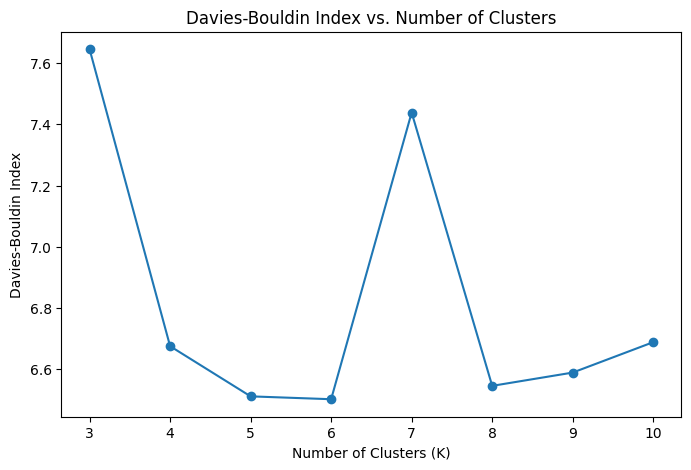

In [386]:
# Plotting K vs. Davies-Bouldin Index
import matplotlib.pyplot as plt

K_values = list(db_dict.keys())
db_indices = list(db_dict.values())

plt.figure(figsize=(8, 5))
plt.plot(K_values, db_indices, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show()

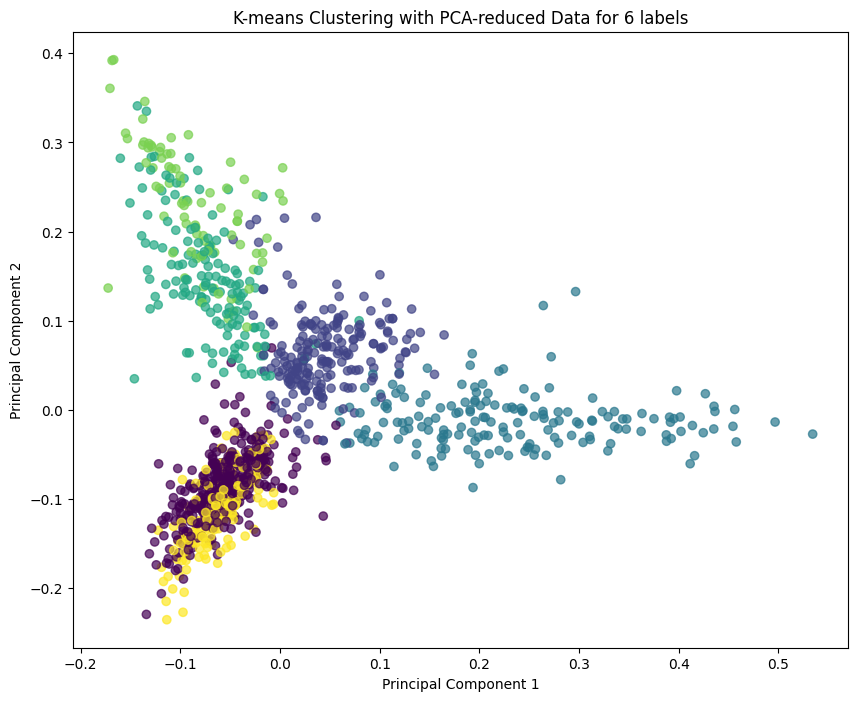

In [387]:
from sklearn.decomposition import PCA

# Reduce the TF-IDF matrix to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())




# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=optimal_labels, cmap='viridis', alpha=0.7)
plt.title(f'K-means Clustering with PCA-reduced Data for {np.unique(optimal_labels).size} labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## cluster digests:


In [388]:
# Get the top unigrams and bigrams for each cluster
from collections import Counter

def print_digests(optimal_cluster, cleaned_documents):
    for cluster_num in range(optimal_cluster):
        # Get indices of documents in the cluster
        cluster_indices = np.where(optimal_labels == cluster_num)[0]
        
        # Get the cleaned documents for these indices
        cluster_docs = [cleaned_documents[i] for i in cluster_indices]
        
        # Join all documents into a single string
        cluster_text = ' '.join(cluster_docs)
        
        # Tokenize the text
        tokens = cluster_text.split()
        
        # Count unigrams
        unigram_counts = Counter(tokens)
        top_unigrams = unigram_counts.most_common(10)
        
        # Count bigrams
        bigrams = zip(tokens, tokens[1:])
        bigram_counts = Counter(bigrams)
        top_bigrams = bigram_counts.most_common(10)
        
        print(f"\nCluster {cluster_num} Digests:")
        print("Top Unigrams:")
        for word, count in top_unigrams:
            print(f"{word}: {count}")
        print("Top Bigrams:")
        for (word1, word2), count in top_bigrams:
            print(f"{word1} {word2}: {count}")


In [392]:
print_digests(optimal_cluster=optimal_cluster, cleaned_documents=cleaned_documents)


Cluster 0 Digests:
Top Unigrams:
track: 171
measur: 86
propos: 83
control: 73
algorithm: 69
filter: 63
object: 62
comput: 55
camera: 53
accuraci: 52
Top Bigrams:
comput vision: 27
object track: 17
track algorithm: 16
displac measur: 16
park slot: 13
eye track: 12
optic flow: 11
correl filter: 10
detect track: 9
improv accuraci: 9

Cluster 1 Digests:
Top Unigrams:
robot: 751
control: 160
task: 133
learn: 118
develop: 112
perform: 107
result: 101
propos: 99
design: 96
environ: 95
Top Bigrams:
soft robot: 49
d print: 20
mobil robot: 17
robot arm: 16
robot system: 14
autonom robot: 14
machin learn: 13
robot hand: 12
walk speed: 12
swarm robot: 11

Cluster 2 Digests:
Top Unigrams:
secur: 272
quantum: 171
protocol: 169
propos: 161
cryptographi: 155
implement: 133
comput: 129
attack: 128
key: 125
algorithm: 117
Top Bigrams:
quantum comput: 53
iot devic: 27
key exchang: 20
public key: 17
internet thing: 16
lightweight cryptographi: 16
ellipt curv: 16
polynomi multipl: 15
inform secur: 14
key 

### Improvement with part c)

trying out a more comprehensive stopword list!

In [389]:

custom_stopwords = {'abstract', 'title', 'method', 'result', 'study', 'approach', 'data', 'using',"propos", "use", "system", "model", "paper", 
    "result", "perform", "base", "show", "present", 
    "propos scheme", "paper propos", "result show"}

# Initialize the Preprocessor
preprocessor = Preprocessor(documents, custom_stopwords= custom_stopwords)

# Run the full preprocessing pipeline
cleaned_documents = preprocessor.preprocess()






In [390]:

tfidf_vectorizer = TfidfVectorizer(
    # ngram_range: specifies the range of n-grams to extract from the text data
    # (1, 2) means both unigrams and bigrams will be considered
    ngram_range=(1, 2),
    # min_df: minimum document frequency; ignore terms that appear in less than this number of documents
    min_df=5,
    # max_df: maximum document frequency; ignore terms that appear in more than this fraction of documents
    max_df=0.8,
    # stop_words: list of stop words to ignore in the vectorization process
    stop_words=list(stop_words),
    # lowercase: convert all the text to lowercase
    lowercase=True,
    # use_idf: enable inverse-document-frequency reweighting
    use_idf=True,
    # norm: specifies the norm used to normalize the vectors
    # 'l2' is the Euclidean norm, which scales the vectors to unit length
    norm='l2'
)

tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_documents)

feature_names = tfidf_vectorizer.get_feature_names_out()

8


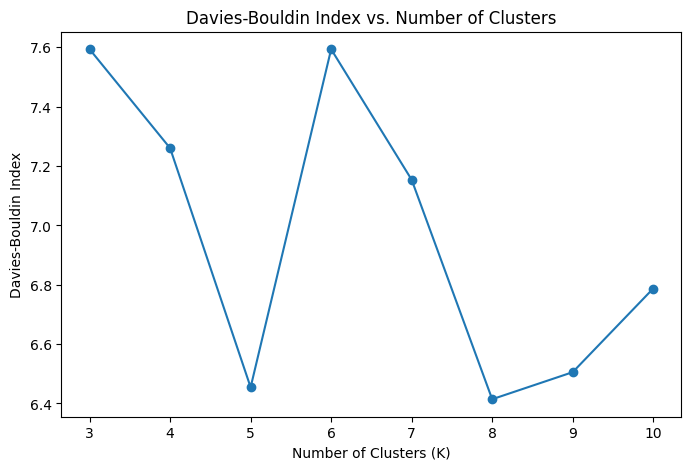

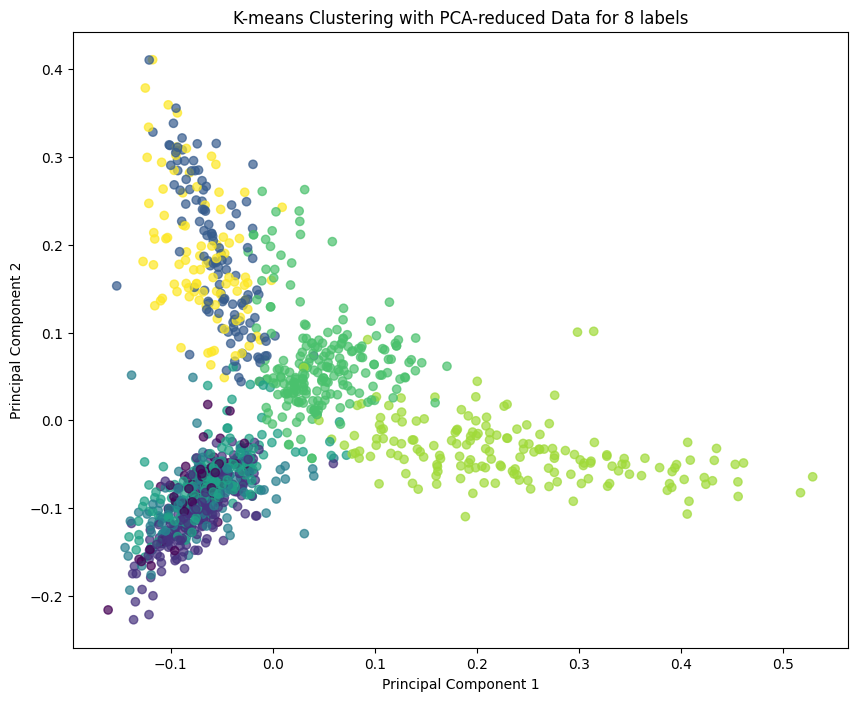

In [391]:
cluster_range = np.arange(3, 11)
db_dict = db_score_clusters(tfidf_matrix=tfidf_matrix, cluster_range=cluster_range)
optimal_cluster = find_optimal_cluster(db_dict=db_dict)
print(optimal_cluster)
optimal_kmeans = KMeans(n_clusters=optimal_cluster)
optimal_kmeans.fit(tfidf_matrix)
optimal_labels = optimal_kmeans.labels_


K_values = list(db_dict.keys())
db_indices = list(db_dict.values())

plt.figure(figsize=(8, 5))
plt.plot(K_values, db_indices, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show()



pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())




# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=optimal_labels, cmap='viridis', alpha=0.7)
plt.title(f'K-means Clustering with PCA-reduced Data for {np.unique(optimal_labels).size} labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [393]:

print_digests(optimal_cluster=optimal_cluster, cleaned_documents=cleaned_documents)


Cluster 0 Digests:
Top Unigrams:
track: 171
measur: 86
propos: 83
control: 73
algorithm: 69
filter: 63
object: 62
comput: 55
camera: 53
accuraci: 52
Top Bigrams:
comput vision: 27
object track: 17
track algorithm: 16
displac measur: 16
park slot: 13
eye track: 12
optic flow: 11
correl filter: 10
detect track: 9
improv accuraci: 9

Cluster 1 Digests:
Top Unigrams:
robot: 751
control: 160
task: 133
learn: 118
develop: 112
perform: 107
result: 101
propos: 99
design: 96
environ: 95
Top Bigrams:
soft robot: 49
d print: 20
mobil robot: 17
robot arm: 16
robot system: 14
autonom robot: 14
machin learn: 13
robot hand: 12
walk speed: 12
swarm robot: 11

Cluster 2 Digests:
Top Unigrams:
secur: 272
quantum: 171
protocol: 169
propos: 161
cryptographi: 155
implement: 133
comput: 129
attack: 128
key: 125
algorithm: 117
Top Bigrams:
quantum comput: 53
iot devic: 27
key exchang: 20
public key: 17
internet thing: 16
lightweight cryptographi: 16
ellipt curv: 16
polynomi multipl: 15
inform secur: 14
key 